In [1]:
from copy import deepcopy as copy
%matplotlib widget

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import subprocess
import pickle
from scipy.stats import describe
from tqdm import tqdm

from astropy.io import fits

from lvmdrp.core import image
from lvmdrp.functions import imageMethod, rssMethod

import seaborn as sns

sns.set(context="talk", style="ticks", palette="husl", color_codes=True)

import warnings
warnings.filterwarnings("ignore")


def read_nist_reference(filename, wl_window):
    wli, wlf = wl_window
    ref_nist_or = pd.read_csv(
        filename, sep="\s+", comment="#").set_index("Wavelength")
    ref_nist_or = ref_nist_or.loc[(
        wli <= ref_nist_or.index) & (ref_nist_or.index <= wlf)]

    del_wl = np.diff(ref_nist_or.index).min()
    new_wl = np.unique(
        np.arange(wli, wlf+del_wl, del_wl).tolist()+ref_nist_or.index.to_list())
    ref_nist_rs = ref_nist_or.reindex(new_wl)

    return ref_nist_or, ref_nist_rs


In [2]:
# data root path
LVM_DEV = os.path.expandvars("$LVMHUB")
LVM_ROOT = os.path.join(LVM_DEV, "data.sdss5.org/sas/sdsswork/data/lvm")
LVM_DATA_LAB = os.path.join(LVM_ROOT, "lab")

In [3]:

frames_meta = pd.read_csv(os.path.join(LVM_DATA_LAB, "LVMI Exposure List - Sheet1.csv"))
frames_meta.filename = frames_meta.filename.str.strip()
frames_meta.set_index(["mjd","filename"], inplace=True)
frames_meta = frames_meta.loc[~frames_meta.index.duplicated(keep="first")]
frames_meta = frames_meta.mask(frames_meta==-999)
frames_meta = frames_meta.drop(columns=frames_meta.filter(like="Unnamed"))
frames_meta = frames_meta.dropna(how="all", axis="columns").dropna(how="all", axis="index")

print(f"No. lab frames: {len(frames_meta)}")

No. lab frames: 7655


In [4]:
frame_paths = sorted([os.path.join(root,file) for root, _, files in os.walk(LVM_DATA_LAB) for file in files if (pd.to_numeric(os.path.basename(root),errors="ignore"),file) in frames_meta.index])
# frame_paths = sorted([os.path.join(root,file) for root, _, files in os.walk(LVM_DATA_LAB) for file in files if file.endswith(".fits") or file.endswith(".fits.gz")])
print(f"frames matched in lab data path: {len(frame_paths)}")

frames matched in lab data path: 7181


In [5]:
frames_header_list_pickle = "_data-lvm/frames_header_list.pk"

# new_index = pd.MultiIndex.from_tuples(((pd.to_numeric(os.path.basename(os.path.dirname(file)),errors="ignore"),os.path.basename(file)) for file in frame_paths), names=("mjd", "filename"))
arc_names = "ARGON XENON HGAR KRYPTON NEON HGNE".split()
lamp_names = "M625L4 FFS MI150 TS LDLS".split()
columns = "SPEC IMAGETYP CCDTEMP1 CCDTEMP2 PRESURE LABTEMP LABHUMID".split() + lamp_names + arc_names

if os.path.isfile(frames_header_list_pickle):
# if False:
    frames_header_list, new_index = pickle.load(open(frames_header_list_pickle, "rb"))
else:
    frames_header_list, new_index = [], []
    for idx, frame_path in tqdm(enumerate(frame_paths), total=len(frame_paths), desc="reading metadata from headers", ascii=True):
        try:
            hdr = fits.getheader(frame_path, ext=0)
        except OSError:
            continue
        
        frames_header_list.append([hdr.get(column, np.nan) for column in columns])
        # new_index.append((hdr.get("MJD", np.nan), hdr.get("FILENAME", np.nan)))
        new_index.append((
            pd.to_numeric(os.path.basename(os.path.dirname(frame_path)),errors="ignore"),
            os.path.basename(frame_path)
        ))
    
    pickle.dump((frames_header_list, new_index), open(frames_header_list_pickle, "wb"))

In [6]:

frames_header = pd.DataFrame(index=pd.MultiIndex.from_tuples(new_index, names=("mjd", "filename")), columns=columns, data=frames_header_list)
frames_header = frames_header.mask(frames_header==-999).mask(frames_header=="?")

frames_meta_match = frames_meta.reindex(new_index)
frames_meta_match = pd.concat((frames_meta_match, frames_header), axis="columns").sort_index()
frames_meta_match["filepath"] = [f"{LVM_DATA_LAB}/{mjd}/{filename}" for mjd, filename in new_index]
frames_meta_match

exp_no        date location test_no  \
mjd     filename                                                         
59364.0 sdR-s-r1-00000318.fits.gz   318.0  30/05/2021      SBS     NaN   
59365.0 sdR-s-r1-00000325.fits.gz   325.0  31/05/2021      SBS     NaN   
        sdR-s-r1-00000326.fits.gz   326.0  31/05/2021      SBS     NaN   
        sdR-s-r1-00000327.fits.gz   327.0  31/05/2021      SBS     NaN   
        sdR-s-r1-00000328.fits.gz   328.0  31/05/2021      SBS     NaN   
...                                   ...         ...      ...     ...   
59655.0 sdR-s-z1-00003102.fits.gz  3102.0  17/03/2022      SBS     NaN   
        sdR-s-z1-00003103.fits.gz  3103.0  17/03/2022      SBS     NaN   
        sdR-s-z1-00003104.fits.gz  3104.0  17/03/2022      SBS     NaN   
        sdR-s-z1-00003105.fits.gz  3105.0  17/03/2022      SBS     NaN   
        sdR-s-z1-00003106.fits.gz  3106.0  17/03/2022      SBS     NaN   

                                  test_iteration spec channel sources  \
mjd     filename                                                        
59364.0 sdR-s-r1-00000318.fits.gz            NaN  sp1      r1     NaN   
59365.0 sdR-s-r1-00000325.fits.gz            NaN  sp1      r1     NaN   
        sdR-s-r1-00000326.fits.gz            NaN  sp1      r1     NaN   
        sdR-s-r1-00000327.fits.gz            NaN  sp1      r1     NaN   
        sdR-s-r1-00000328.fits.gz            NaN  sp1      r1     NaN   
...                                          ...  ...     ...     ...   
59655.0 sdR-s-z1-00003102.fits.gz            NaN  sp1      z1     NaN   
        sdR-s-z1-00003103.fits.gz            NaN  sp1      z1     NaN   
        sdR-s-z1-00003104.fits.gz            NaN  sp1      z1   Argon   
        sdR-s-z1-00003105.fits.gz            NaN  sp1      z1     NaN   
        sdR-s-z1-00003106.fits.gz            NaN  sp1      z1     NaN   

                                  lamp_current hartmanns  ... MI150   TS LDLS  \
mjd     filename                                          ...                   
59364.0 sdR-s-r1-00000318.fits.gz          NaN       NaN  ...   NaN  NaN  NaN   
59365.0 sdR-s-r1-00000325.fits.gz          NaN       NaN  ...   NaN  NaN  NaN   
        sdR-s-r1-00000326.fits.gz          NaN       NaN  ...   NaN  NaN  NaN   
        sdR-s-r1-00000327.fits.gz          NaN       NaN  ...   NaN  NaN  NaN   
        sdR-s-r1-00000328.fits.gz          NaN       NaN  ...   NaN  NaN  NaN   
...                                        ...       ...  ...   ...  ...  ...   
59655.0 sdR-s-z1-00003102.fits.gz          NaN       NaN  ...   NaN  NaN  NaN   
        sdR-s-z1-00003103.fits.gz          NaN       NaN  ...   NaN  NaN  NaN   
        sdR-s-z1-00003104.fits.gz          NaN       NaN  ...   NaN  NaN   ON   
        sdR-s-z1-00003105.fits.gz          NaN       NaN  ...   NaN  NaN  NaN   
        sdR-s-z1-00003106.fits.gz          NaN       NaN  ...   NaN  NaN  NaN   

                                  ARGON XENON HGAR KRYPTON NEON HGNE  \
mjd     filename                                                       
59364.0 sdR-s-r1-00000318.fits.gz   NaN   NaN  NaN     NaN  NaN  NaN   
59365.0 sdR-s-r1-00000325.fits.gz   NaN   NaN  NaN     NaN  NaN  NaN   
        sdR-s-r1-00000326.fits.gz   NaN   NaN  NaN     NaN  NaN  NaN   
        sdR-s-r1-00000327.fits.gz   NaN   NaN  NaN     NaN  NaN  NaN   
        sdR-s-r1-00000328.fits.gz   NaN   NaN  NaN     NaN  NaN  NaN   
...                                 ...   ...  ...     ...  ...  ...   
59655.0 sdR-s-z1-00003102.fits.gz   NaN   NaN  NaN     NaN  NaN  NaN   
        sdR-s-z1-00003103.fits.gz   NaN   NaN  NaN     NaN  NaN  NaN   
        sdR-s-z1-00003104.fits.gz   OFF   OFF  OFF     OFF  OFF  OFF   
        sdR-s-z1-00003105.fits.gz   NaN   NaN  NaN     NaN  NaN  NaN   
        sdR-s-z1-00003106.fits.gz   NaN   NaN  NaN     NaN  NaN  NaN   

                                                                            filepath  
mjd     filename                            

<AxesSubplot:>

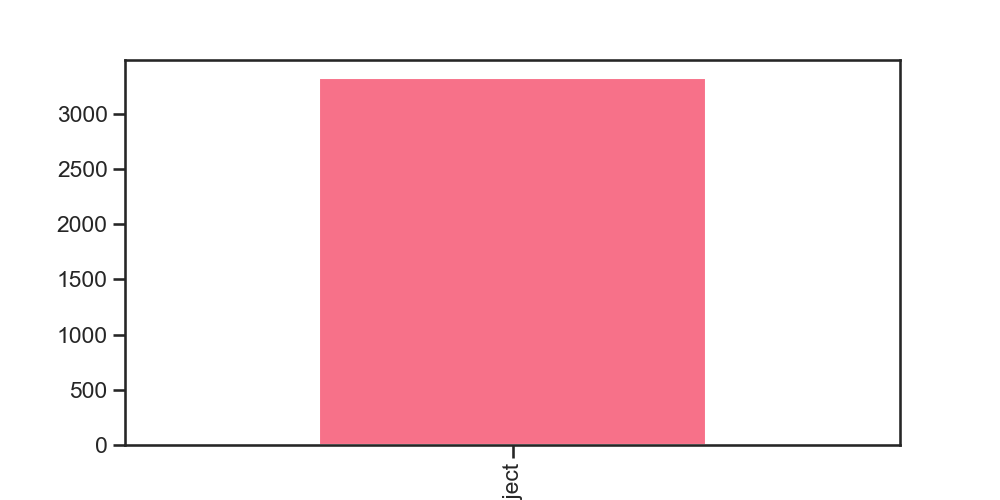

In [100]:
# clean_frames = frames_meta_match.loc[(pd.to_numeric(frames_meta_match.ccd_temp,errors="coerce")<0)&(~frames_meta_match.notes.fillna("").str.contains("bad", case=False))]
# clean_frames = frames_meta_match.loc[frames_meta_match.exp_no.isin(np.arange(1313, 1328+1, dtype=int))]
# clean_frames = frames_meta_match.loc[frames_meta_match.exp_no.isin(np.arange(1545, 1638+1, dtype=int))]
clean_frames = frames_meta_match.loc[frames_meta_match["IMAGETYP"].isin(["object"])]
clean_frames.IMAGETYP.value_counts().plot(kind="bar", figsize=(10,5))

In [101]:
clean_frames.loc[:, ["exp_no", "date", 'SPEC', 'IMAGETYP'] + lamp_names + arc_names]

exp_no        date SPEC IMAGETYP M625L4  \
mjd     filename                                                             
59431.0 sdR-s-b1-00000376.fits.gz   376.0  05/08/2021  sp1   object    OFF   
        sdR-s-r1-00000376.fits.gz   376.0  05/08/2021  sp1   object    OFF   
59433.0 sdR-s-b1-00000377.fits.gz   377.0  07/08/2021  sp1   object    OFF   
        sdR-s-b1-00000379.fits.gz   379.0  07/08/2021  sp1   object    OFF   
        sdR-s-r1-00000377.fits.gz   377.0  07/08/2021  sp1   object    OFF   
...                                   ...         ...  ...      ...    ...   
59655.0 sdR-s-z1-00003080.fits.gz  3080.0  17/03/2022  sp1   object    NaN   
        sdR-s-z1-00003082.fits.gz  3082.0  17/03/2022  sp1   object    NaN   
        sdR-s-z1-00003084.fits.gz  3084.0  17/03/2022  sp1   object    NaN   
        sdR-s-z1-00003086.fits.gz  3086.0  17/03/2022  sp1   object    NaN   
        sdR-s-z1-00003101.fits.gz  3101.0  17/03/2022  sp1   object    NaN   

                                   FFS MI150   TS LDLS ARGON XENON HGAR  \
mjd     filename                                                          
59431.0 sdR-s-b1-00000376.fits.gz  NaN    ON  NaN  NaN   NaN   OFF  NaN   
        sdR-s-r1-00000376.fits.gz  NaN    ON  NaN  NaN   NaN   OFF  NaN   
59433.0 sdR-s-b1-00000377.fits.gz  NaN   OFF  NaN  NaN   NaN   OFF  NaN   
        sdR-s-b1-00000379.fits.gz  NaN   OFF  NaN  NaN   NaN   OFF  NaN   
        sdR-s-r1-00000377.fits.gz  NaN   OFF  NaN  NaN   NaN   OFF  NaN   
...                                ...   ...  ...  ...   ...   ...  ...   
59655.0 sdR-s-z1-00003080.fits.gz  NaN   NaN  NaN  OFF   OFF   OFF   ON   
        sdR-s-z1-00003082.fits.gz  NaN   NaN  NaN  OFF   OFF   OFF   ON   
        sdR-s-z1-00003084.fits.gz  NaN   NaN  NaN  OFF   OFF   OFF   ON   
        sdR-s-z1-00003086.fits.gz  NaN   NaN  NaN  NaN   NaN   NaN  NaN   
        sdR-s-z1-00003101.fits.gz  NaN   NaN  NaN  NaN   NaN   NaN  NaN   

                                  KRYPTON NEON HGNE  
mjd     filename                                     
59431.0 sdR-s-b1-00000376.fits.gz     NaN  NaN  NaN  
        sdR-s-r1-00000376.fits.gz     NaN  NaN  NaN  
59433.0 sdR-s-b1-00000377.fits.gz     NaN  NaN  NaN  
        sdR-s-b1-00000379.fits.gz     NaN  NaN  NaN  
        sdR-s-r1-00000377.fits.gz     NaN  NaN  NaN  
...                                   ...  ...  ...  
59655.0 sdR-s-z1-00003080.fits.gz     OFF  OFF  OFF  
        sdR-s-z1-00003082.fits.gz     OFF  OFF  OFF  
        sdR-s-z1-00003084.fits.gz     OFF  OFF  OFF  
        sdR-s-z1-00003086.fits.gz     NaN  NaN  NaN  
        sdR-s-z1-00003101.fits.gz     NaN  NaN  NaN  

[3321 rows x 15 columns]

In [102]:
# dark_frames = clean_frames.loc[clean_frames.IMAGETYP=="dark"].sort_values("date", ascending=False)
# bias_frames = clean_frames.loc[clean_frames.IMAGETYP=="bias"].sort_values("date", ascending=False)
# flat_frames = clean_frames.loc[clean_frames.IMAGETYP=="flat"].sort_values("date", ascending=False)
# lamp_frames = clean_frames.loc[clean_frames.IMAGETYP=="object"].sort_values("date", ascending=False)

In [105]:
# arc_path = clean_frames.loc[clean_frames.NEON=="ON"].iloc[-1].filepath
# subprocess.run(f"ds9 {arc_path}".split())
# cont_path = clean_frames.loc[clean_frames.LDLS=="ON"].iloc[-1].filepath
# subprocess.run(f"ds9 {cont_path}".split())

# 360-593 nm (Blue channel CCDs)
# 566-772 nm (Red channel CCDs)
# 747-980 nm (NIR channel CCDs)
CHANNEL_WL = {"b1": (3600, 5930), "r1": (5660, 7720), "z1": (7470, 9800)}
CHANNEL = "b1"
ARC_NAME = "NEON"
ARC_NAMES = copy(arc_names)
ARC_NAMES.remove(ARC_NAME)
CON_NAME = lamp_names[4]
CON_NAMES = copy(lamp_names)
CON_NAMES.remove(CON_NAME)

mask_channel = clean_frames.index.get_level_values("filename").str.contains(CHANNEL)


iframe = -1
cont_path = clean_frames.loc[mask_channel & (clean_frames.LDLS == "ON")].iloc[iframe].filepath
cont_name = os.path.basename(cont_path).replace(".fits.gz", "")

# arc_path = clean_frames.loc[mask_channel&(clean_frames.NEON=="ON")].iloc[iframe].filepath#.replace("z1", CHANNEL)
arc_path = clean_frames.loc[mask_channel&(clean_frames[ARC_NAME]=="ON")&(clean_frames[ARC_NAMES].fillna("OFF")=="OFF").all(axis="columns")].iloc[iframe].filepath
arc_name = os.path.basename(arc_path).replace(".fits.gz", "")

cont_name, arc_name

('sdR-s-b1-00002999', 'sdR-s-b1-00002470')

In [107]:
f = fits.open(arc_path)
f[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                   16 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 4120                                                  
NAXIS2  =                 4080                                                  
FILENAME= 'sdR-s-b1-00002470.fits.gz' / File basename                           
EXPNO   =                 2470 / Exposure number                                
SPEC    = 'sp1     '           / Spectrograph name                              
OBSERVAT= 'LCO     '           / Observatory                                    
OBSTIME = '2022-03-08T20:04:46.081' / Start of the observation                  
MJD     =                59646 / Modified Julian Date                           
EXPTIME =                 90.0 / Exposure time                                  
DARKTIME=                 90

41 Fibers found


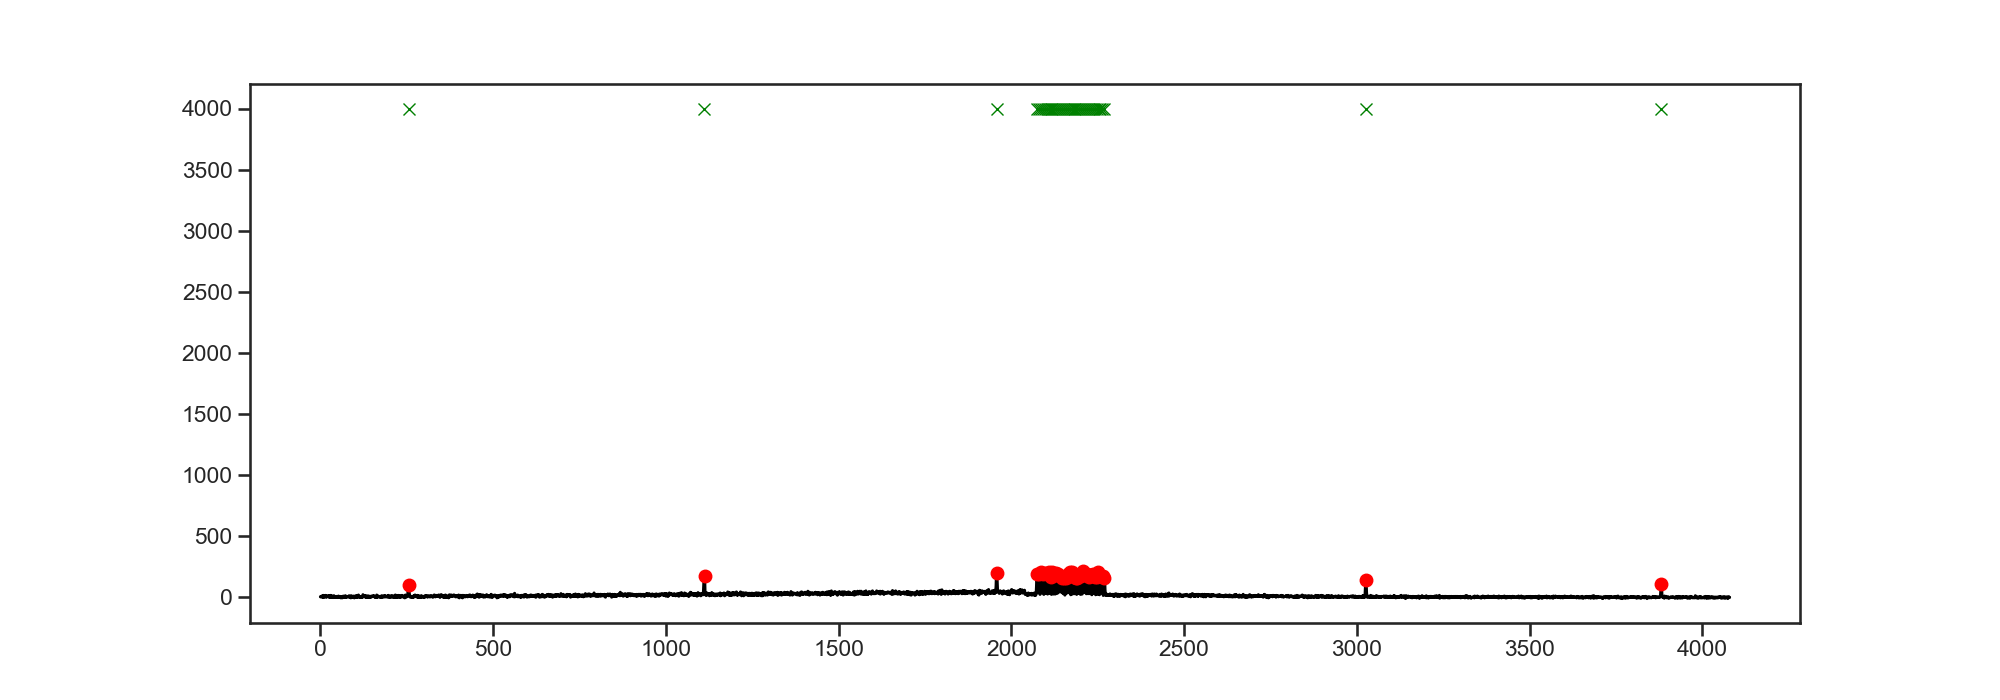

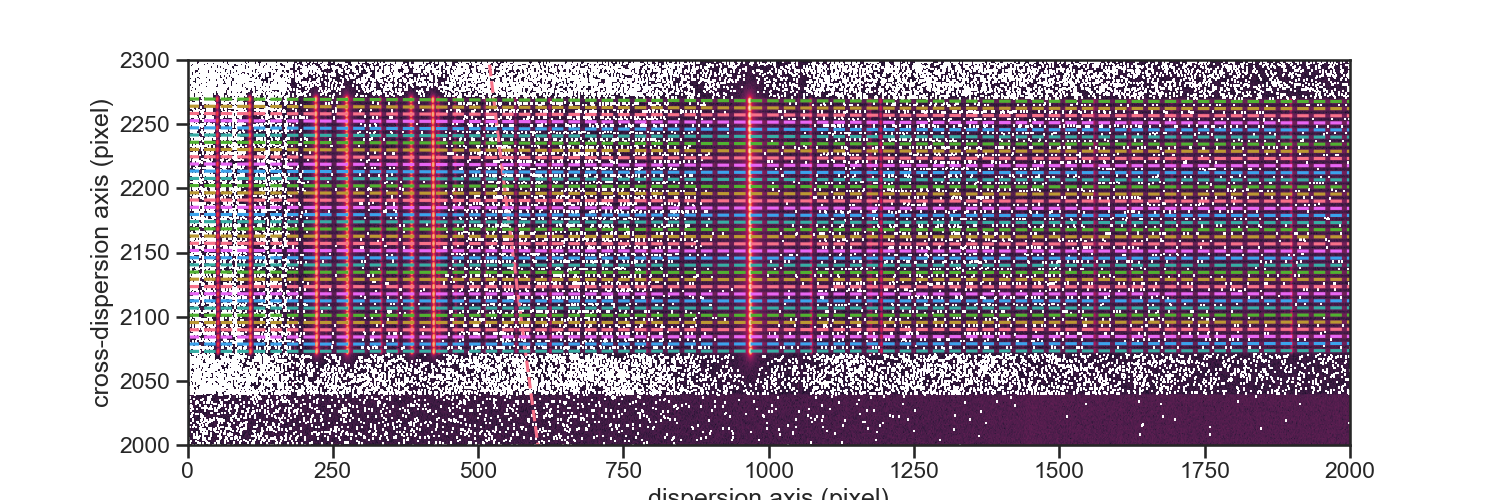

In [108]:
# preprocess frames
# remove overscan regions & compute bias
# remove bias
# join amplifiers
imageMethod.preprocRawFrame_drp(
	cont_path,
    channel=CHANNEL,
	out_image=f"_data-lvm/{cont_name}.pre.fits",
	boundary_x="1,2040",
	boundary_y="1,2040",
	positions="00,10,01,11",
	orientation="S,S,S,S"
)
# subprocess.run(f"ds9 _data-lvm/{cont_name}.pre.fits".split())

# remover rayos cosmicos (no es necesario para datos del lab, tiempos de exposicion cortos). El resultado es guardado en *cosmic
# imageMethod.LACosmic_drp(os.path.join(LVM_ROOT,f"{cont_name}.fits"), out_image=f"_data-lvm/{cont_name}.cosmic.fits", increase_radius=1, flim="1.3", parallel='1')
imageMethod.LACosmic_drp(
    f"_data-lvm/{cont_name}.pre.fits",
    out_image=f"_data-lvm/{cont_name}.cosmic.fits",
    increase_radius=1, flim="1.3", parallel='5'
)

# deteccion de picos en el eje de cros-dispersion para un pixel dado. El resultado es guardado en *trace
# imageMethod.findPeaksAuto_drp(f"_data-lvm/{cont_name}.cosmic.fits", out_peaks_file=f"_data-lvm/{cont_name}.trace.peaks", nfibers=382)
imageMethod.findPeaksAuto_drp(
    f"_data-lvm/{cont_name}.cosmic.fits",
    out_peaks_file=f"_data-lvm/{cont_name}.trace.peaks",
    disp_axis="X", threshold="5000", slice="3696", nfibers="41", median_box="1", median_cross="1", method="gauss", init_sigma="0.5", verbose=1
)

# trazado de picos, consiste en localizar las fibras a lo largo del eje de cros-dispersion usando la deteccion de picos en el paso anterior
# es equivalente a propagar la localizacion de los picos para un pixel a lo largo del eje de dispersion. El resultado es guardado en *trc
# imageMethod.tracePeaks_drp(
#     f"_data-lvm/{cont_name}.cosmic.fits",
#     peaks_file=f"_data-lvm/{cont_name}.trace.peaks",
#     trace_out=f"_data-lvm/{cont_name}.trc.fits",
#     steps=30,
#     method="gauss",
#     threshold_peak=50, poly_disp=5, coadd=30, verbose=0
# )
imageMethod.tracePeaks_drp(
    f"_data-lvm/{cont_name}.cosmic.fits",
    peaks_file=f"_data-lvm/{cont_name}.trace.peaks", trace_out=f"_data-lvm/{cont_name}.trc.fits",
    steps=30, method="gauss", threshold_peak=50, poly_disp=5, coadd=30, verbose=0
)
cosmic = fits.open(f"_data-lvm/{cont_name}.cosmic.fits")
trace = fits.open(f"_data-lvm/{cont_name}.trc.fits")

plt.figure(figsize=(15,5))
plt.imshow(np.log10(cosmic[0].data), origin="lower")
plt.gca().set_aspect("auto")
plt.xlim(0,2000)
plt.ylim(2000,2300)
plt.xlabel("dispersion axis (pixel)")
plt.ylabel("cross-dispersion axis (pixel)")

# plt.figure(figsize=(20,))
xx = np.arange(cosmic[0].data.shape[1])
for iy in range(trace[0].data.shape[0]):
    yy = trace[0].data[iy,:]
    plt.plot(xx, yy, "--")

# remover luz directa (stray light). El resultado se guarda en *back (el fondo de luz directa) y *stray (el frame corregido)
# imageMethod.subtractStraylight_drp(
#     f"_data-lvm/{cont_name}.cosmic.fits",
#     f"_data-lvm/{cont_name}.trc.fits",
#     f"_data-lvm/{cont_name}.back.fits",
#     f"_data-lvm/{cont_name}.stray.fits", aperture=40, poly_cross=2, smooth_gauss=30
# )
imageMethod.subtractStraylight_drp(
    f"_data-lvm/{cont_name}.cosmic.fits",
    f"_data-lvm/{cont_name}.trc.fits",
    f"_data-lvm/{cont_name}.back.fits",
    f"_data-lvm/{cont_name}.stray.fits",
    aperture=40, poly_cross=2, smooth_gauss=30
)
# subprocess.run(f"ds9 _data-lvm/{cont_name}.cosmic.fits _data-lvm/{cont_name}.stray.fits".split(), capture_output=True)

# traza el ancho de cada espectro a lo largo de cross-dispersion
# El resultado es guardado en *fwhm
# imageMethod.traceFWHM_drp(
#     f"_data-lvm/{cont_name}.stray.fits",
#     f"_data-lvm/{cont_name}.trc.fits",
#     f"_data-lvm/{cont_name}.fwhm.fits",
#     blocks=32, steps=30, coadd=20, threshold_flux=50.0, poly_disp=5, clip="1.5,4.0"
# )
imageMethod.traceFWHM_drp(
    f"_data-lvm/{cont_name}.stray.fits",
    f"_data-lvm/{cont_name}.trc.fits",
    f"_data-lvm/{cont_name}.fwhm.fits",
    blocks=32, steps=30, coadd=20, threshold_flux=50.0, poly_disp=5, clip="1.5,4.0"
)
# subprocess.run(f"ds9 _data-lvm/{cont_name}.fwhm.fits".split())

# extraccion (usando el FWHM), usando como entrada el FWHM resultado de traceFWHM_drp. El resultado es guardado en *ms
# imageMethod.extractSpec_drp(
#     f"_data-lvm/{cont_name}.stray.fits",
#     f"_data-lvm/{cont_name}.trc.fits",
#     f"_data-lvm/{cont_name}.ms.fits",
#     fwhm=f"_data-lvm/{cont_name}.fwhm.fits",
#     method="optimal", parallel=5
# )
imageMethod.extractSpec_drp(
    f"_data-lvm/{cont_name}.stray.fits",
    f"_data-lvm/{cont_name}.trc.fits",
    f"_data-lvm/{cont_name}.ms.fits",
    fwhm=f"_data-lvm/{cont_name}.fwhm.fits",
    parallel=5, method="optimal"
)

In [109]:
# extraccion del arco
imageMethod.preprocRawFrame_drp(
	arc_path,
    channel=CHANNEL,
	out_image=f"_data-lvm/{arc_name}.pre.fits",
	boundary_x="1,2040",
	boundary_y="1,2040",
	positions="00,10,01,11",
	orientation="S,S,S,S"
)
# subprocess.run(f"ds9 _data-lvm/{arc_name}.pre.fits".split())

# remover rayos cosmicos (no es necesario para datos del lab, tiempos de exposicion cortos). El resultado es guardado en *cosmic
imageMethod.LACosmic_drp(
    f"_data-lvm/{arc_name}.pre.fits",
    out_image=f"_data-lvm/{arc_name}.cosmic.fits",
    increase_radius=1, flim="1.3", parallel='5'
)
imageMethod.subtractStraylight_drp(
    f"_data-lvm/{arc_name}.cosmic.fits",
    f"_data-lvm/{cont_name}.trc.fits",
    f"_data-lvm/{arc_name}.back.fits",
    f"_data-lvm/{arc_name}.stray.fits",
    aperture=40, poly_cross=2, smooth_gauss=30
)
imageMethod.extractSpec_drp(
    f"_data-lvm/{arc_name}.stray.fits",
    f"_data-lvm/{cont_name}.trc.fits",
    f"_data-lvm/{arc_name}.ms.fits",
    fwhm=f"_data-lvm/{cont_name}.fwhm.fits",
    method="optimal", parallel="5"
)

subprocess.run(f"ds9 _data-lvm/{arc_name}.ms.fits".split())


CompletedProcess(args=['ds9', '_data-lvm/sdR-s-b1-00002470.ms.fits'], returncode=0)

In [110]:
wli, wlf = CHANNEL_WL[CHANNEL]
ised = 21
coad = 10

# neon_ref = pd.read_csv("_data-lvm/neon-lines_desi.txt", sep="\s+", comment="#", names=["Wavelength", "Spectrum", "Spectrograph"]).sort_values("Wavelength").set_index("Wavelength")
# neon_cur_ref = neon_ref.Spectrum
# neon_cur_ref = neon_cur_ref.str.strip().str.isalpha().astype(int)
# neon_cur_ref = neon_cur_ref.loc[(wli<=neon_cur_ref.index)&(neon_cur_ref.index<=wlf)]
# neon_cur_ref = neon_cur_ref.loc[neon_cur_ref!=0]

# print(len(neon_cur_ref))

# del_wl = np.diff(neon_cur_ref.index).min()
# new_wl = np.unique(np.arange(wli, wlf+del_wl, del_wl).tolist()+neon_cur_ref.index.to_list())
# neon_spec = neon_cur_ref.reindex(new_wl).fillna(0)
# # neon_spec.plot(figsize=(17,5))
# # plt.gca().set_yscale("log")

ext, ext_header = fits.getdata(f"_data-lvm/{arc_name}.ms.fits", header=True)
target_spec = ext[ised-coad:ised+coad].sum(axis=0)
# target_spec[target_spec<target_spec.std()] = 0

In [111]:
neon_nist_or, neon_nist = read_nist_reference("_data-lvm/neon-lines-nist.txt", wl_window=(wli,wlf))
xenon_nist_or, xenon_nist = read_nist_reference("_data-lvm/xenon-lines-nist.txt", wl_window=(wli,wlf))
argon_nist_or, argon_nist = read_nist_reference("_data-lvm/argon-lines-nist.txt", wl_window=(wli,wlf))
mercury_nist_or, mercury_nist = read_nist_reference("_data-lvm/mercury-lines-nist.txt", wl_window=(wli,wlf))

ref_current = (neon_nist_or, xenon_nist_or, argon_nist_or, mercury_nist_or)
ref_current = (neon_nist_or, argon_nist_or)
ref_current = (neon_nist_or,)

ref_lines = pd.concat(ref_current, axis="columns")
ref_gr = ref_lines.groupby(ref_lines.columns, axis="columns")

ref_lines = pd.concat((
    ref_gr.get_group("Intensity").agg(np.nansum, axis="columns"),
    ref_gr.get_group("Spectrum").fillna("").agg(
        lambda v: "".join(v), axis="columns")
), axis="columns").rename(columns={0: "Intensity", 1: "Spectrum"})

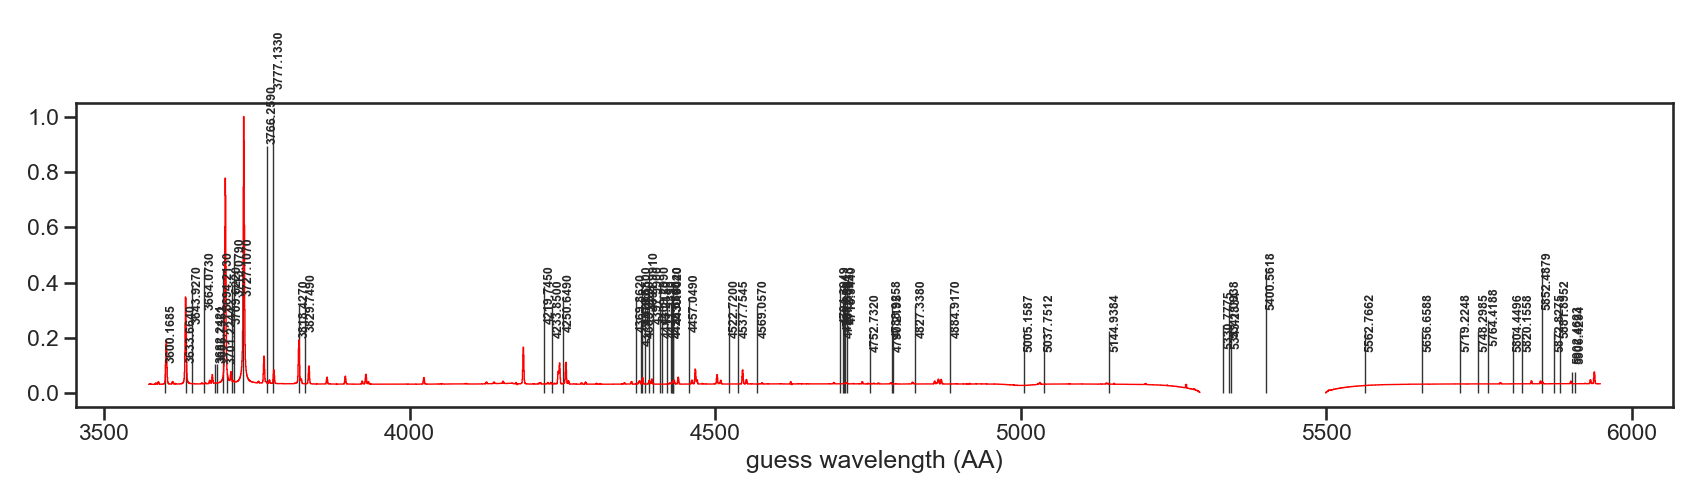

In [140]:
import matplotlib.ticker as plticker


# initial guess: a linear interpolation in the known range
guess_wl = np.linspace(wli, wlf, target_spec.size)

plt.figure(figsize=(17,5))
# plt.vlines(neon_cur_ref.index, ymin=0, ymax=1, colors="0.2", lw=1)
plt.vlines(ref_lines.index, ymin=0, ymax=np.sqrt(0.001+ref_lines.Intensity/ref_lines.Intensity.max()), colors="0.2", lw=1)
if CHANNEL == "b1":
    mask_bad = (5012-5<=guess_wl)&(guess_wl<=5012+5)
    # mask_bad = np.zeros_like(guess_wl, dtype=bool)
    plt.step(
        # guess_wl[~mask_bad],
        0.00001*(guess_wl[~mask_bad] - (26.97 + 3777.1330)
                 )**2 + (guess_wl[~mask_bad] - (26.97 + 3777.1330)) + 3777.1330,
        np.sqrt(0.001+target_spec[~mask_bad][::]/target_spec[~mask_bad].max()), color="r", lw=1)
elif CHANNEL == "r1":
    plt.step(
        # guess_wl,
        -0.00001*(guess_wl + (80.5 - 6929.4673))**2 + 1.05*(guess_wl + (80.5 - 6929.4673)) + 6929.4673,
        (target_spec/target_spec.max()), color="r", lw=1
    )
elif CHANNEL == "z1":
    # best guess for NIR channel
    plt.step(-0.000049*(guess_wl+110-8860)**2+1.05*(guess_wl+110-8860)+8860, (target_spec[::]/target_spec.max()), color="r", lw=1)

for iwl, line in ref_lines.iterrows():
    rel_intensity = (line.Intensity/ref_lines.Intensity.max())
    if rel_intensity > -0.1:
        plt.text(iwl, rel_intensity+0.1,
             f"{iwl:.4f}", rotation=90, ha="left", va="bottom", size=9, fontweight="bold")
plt.xlabel("guess wavelength (AA)")
# plt.yscale("log")
# this locator puts ticks at regular intervals
# loc = plticker.MultipleLocator(base=100)
# plt.gca().xaxis.set_major_locator(loc)
plt.tight_layout()
# neon_spec.mask(neon_spec==0).dropna()
# plt.xlim(3580, 4700)

In [141]:
# plt.figure(figsize=(25,5))
# plt.plot(neon_spec.index, neon_spec.values)
# plt.xlabel("Wavelength")
# plt.ylabel("Intensity")


In [142]:
# from scipy.spatial.distance import euclidean
# from fastdtw import fastdtw


# dist, path = fastdtw(np.log10(1+neon_spec/neon_spec.max()), np.log10(1+target_spec/target_spec.max()), dist=euclidean, radius=100)
# print("distance:", dist)

In [143]:
# ineon, itarget = zip(*path)

# plt.figure(figsize=(25,5))
# plt.plot(np.log10(1+neon_spec.values[list(ineon)]/neon_spec.max()), lw=2)
# plt.plot(np.log10(1+target_spec[list(itarget)]/target_spec.max()), lw=1)

# mask = (neon_spec.values[list(ineon)]!=0)&(target_spec[list(itarget)]>1*np.std(target_spec[list(itarget)]))
# pix_map_table = np.column_stack((np.arange(target_spec.size)[list(itarget)], neon_spec.index.values[list(ineon)], np.ones(len(ineon))))[mask]
# _, idx = np.unique(pix_map_table[:,1], return_index=True)
# with open("_data-lvm/dtw-neon.txt", "w") as f:
#     f.write(f"{ised}\n")
#     np.savetxt(f, pix_map_table[idx], fmt="%.2f %.2f %d")

In [144]:
# np.seterr(all="raise")

# solucion de longitud de onda
# este paso deberia hacerse en simultaneo con el trazado de la FWHM (espacial), solucion simultanea en espacio y wavelength es el spectroperfectionism
# *.res.fits es la LSF
# *.disp.fits es el muestreo en wavelength
wave, fwhm = rssMethod.detWaveSolution_drp(
    f"_data-lvm/{arc_name}.ms.fits",
    f"_data-lvm/{arc_name}.disp.fits",
    f"_data-lvm/{arc_name}.res.fits",
    # f"_data-lvm/neon-lines_cor.txt",
    f"_data-lvm/lvm-neon_nist_{CHANNEL}.txt",
    aperture="7", poly_fwhm="-1,-1", poly_dispersion="-4", rel_flux_limits="0.2,2", flux_min="100.0", verbose="-1"
)
# subprocess.run(f"ds9 {arc_name}.disp.fits {arc_name}.res.fits".split())

# a#adir solucion a los RSS, usando la determinacion de la solucion de longitud de onda en *disp y *res. El resultado es guardado en *rss
# esto no remuestrea los espectros al mismo vector de longitudes de onda
rssMethod.createPixTable_drp(
    f"_data-lvm/{arc_name}.ms.fits",
    f"_data-lvm/{arc_name}.rss.fits",
    f"_data-lvm/{arc_name}.disp.fits", arc_fwhm=f"_data-lvm/{arc_name}.res.fits", cropping=''
)

# remuestrea los espectros a un vector de longitudes de onda comun. Crea *.disp_cor
rssMethod.resampleWave_drp(
    f"_data-lvm/{arc_name}.rss.fits", f"_data-lvm/{arc_name}.disp_cor.fits",
    start_wave=wli, end_wave=wlf, disp_pix="1.0", err_sim="0"
)

# subprocess.run(f"ds9 _data-lvm/{arc_name}.rss.fits _data-lvm/{arc_name}.disp_cor.fits".split())

Start measuring arc lines...


In [145]:
f = fits.open(f"_data-lvm/{arc_name}.disp.fits")
f[0].data[ised,[0,-1]], wli, wlf

(array([3569.6538, 5913.512 ], dtype=float32), 3600, 5930)

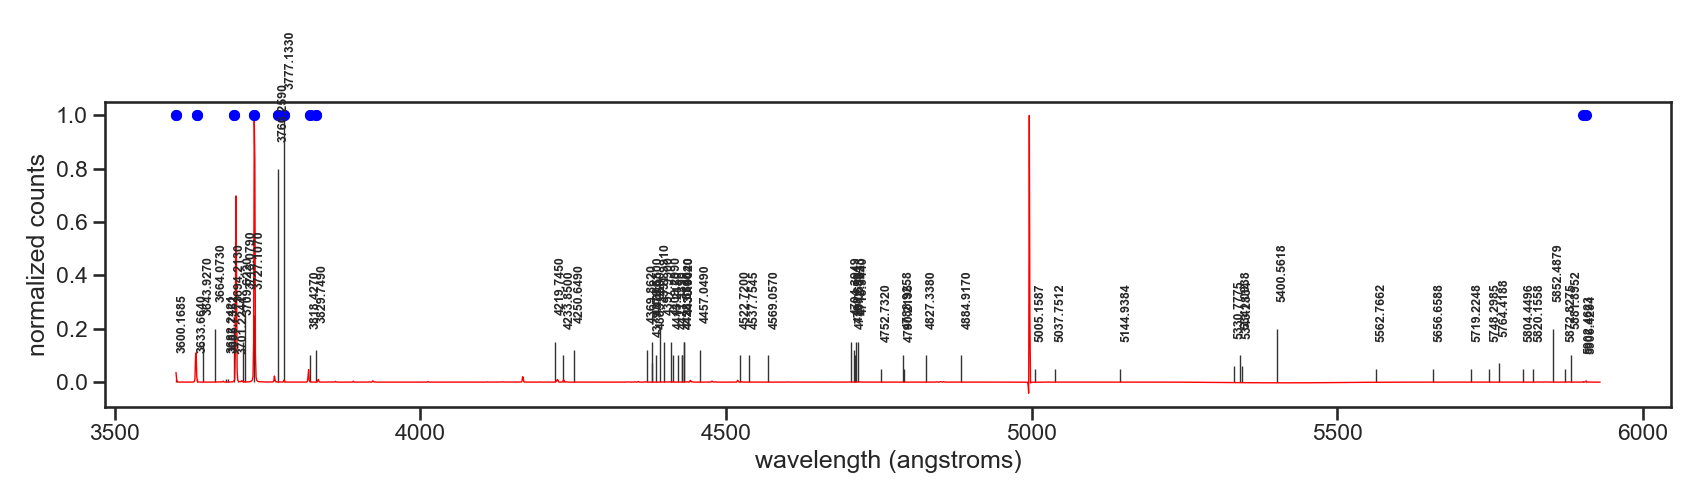

In [147]:
rss = rssMethod.loadRSS(f"_data-lvm/{arc_name}.disp_cor.fits")

ref_table = np.loadtxt(f"_data-lvm/lvm-neon_nist_{CHANNEL}.txt", skiprows=1)
ref_table = ref_table[ref_table[:,2].astype(bool)]

plt.figure(figsize=(17,5))
(neon_nist.Intensity/neon_nist.Intensity.max()).plot(ax=plt.gca(), lw=1, color="0.5")
plt.plot(rss._wave, (rss._data[ised]/rss._data[ised].max()), "r", lw=1)
plt.plot(ref_table[:,1], np.ones_like(ref_table[:,1]), "ob", ms=7)
plt.vlines(neon_nist_or.index, ymin=0, ymax=(neon_nist_or.Intensity/neon_nist_or.Intensity.max()), colors="0.2", lw=1)

for iwl, line in neon_nist_or.iterrows():
    rel_intensity = (line.Intensity/neon_nist_or.Intensity.max())
    if rel_intensity > -0.1:
        plt.text(iwl, rel_intensity+0.1,
             f"{iwl:.4f}", rotation=90, ha="left", va="bottom", size=9, fontweight="bold")

plt.xlabel("wavelength (angstroms)")
plt.ylabel("normalized counts")
plt.tight_layout()

In [148]:
f = fits.open(f"_data-lvm/{arc_name}.rss.fits")
f.info()

Filename: _data-lvm/sdR-s-b1-00002470.rss.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      66   (4079, 41)   float32   
  1  WAVE          1 ImageHDU         8   (4079, 41)   float32   
  2  INSTFWHM      1 ImageHDU         8   (4079, 41)   float32   
  3  ERROR         1 ImageHDU         8   (4079, 41)   float32   
  4  BADPIX        1 ImageHDU         8   (4079, 41)   uint8   


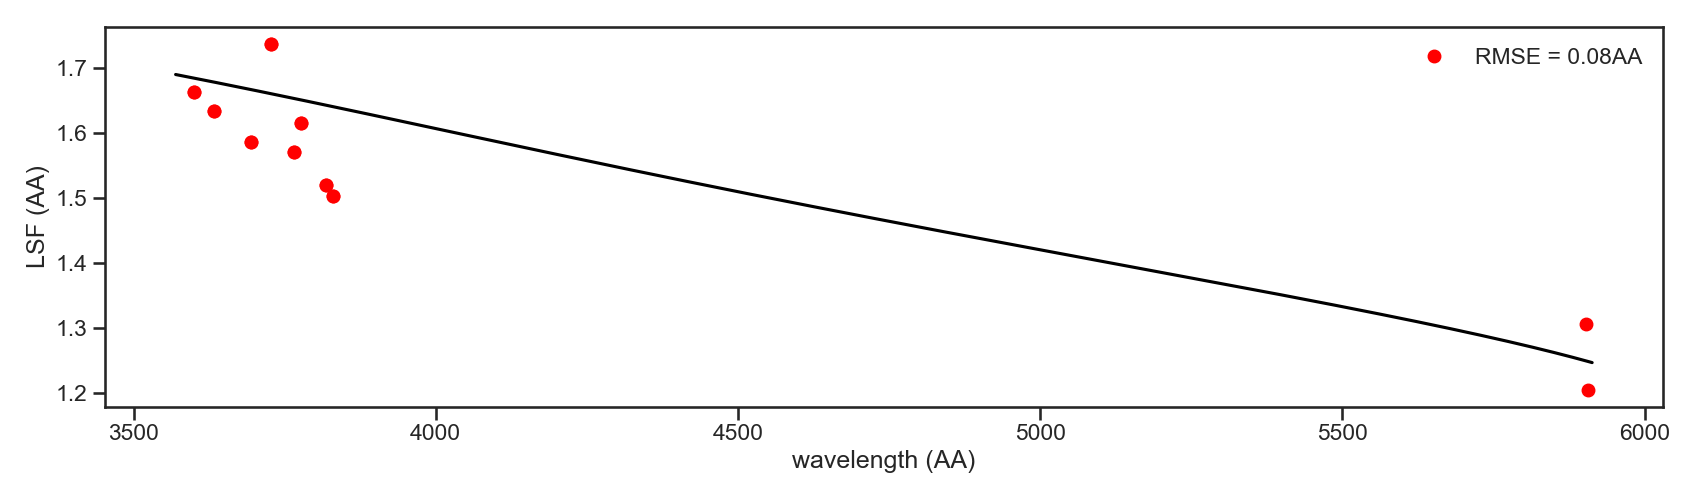

In [149]:
def rmse(model, data):
    return np.sqrt(np.sum((model-data)**2)/data.size)

plt.figure(figsize=(17,5))
plt.plot(f[1].data[ised], f[2].data[ised], "k")

error = rmse(np.interp(ref_table[:,1], f[1].data[ised], f[2].data[ised]), fwhm)
plt.plot(ref_table[:,1], fwhm, "or", label=f"RMSE = {error:.2f}AA")

plt.legend(loc=0, frameon=False)
plt.xlabel("wavelength (AA)")
plt.ylabel("LSF (AA)")
plt.tight_layout()

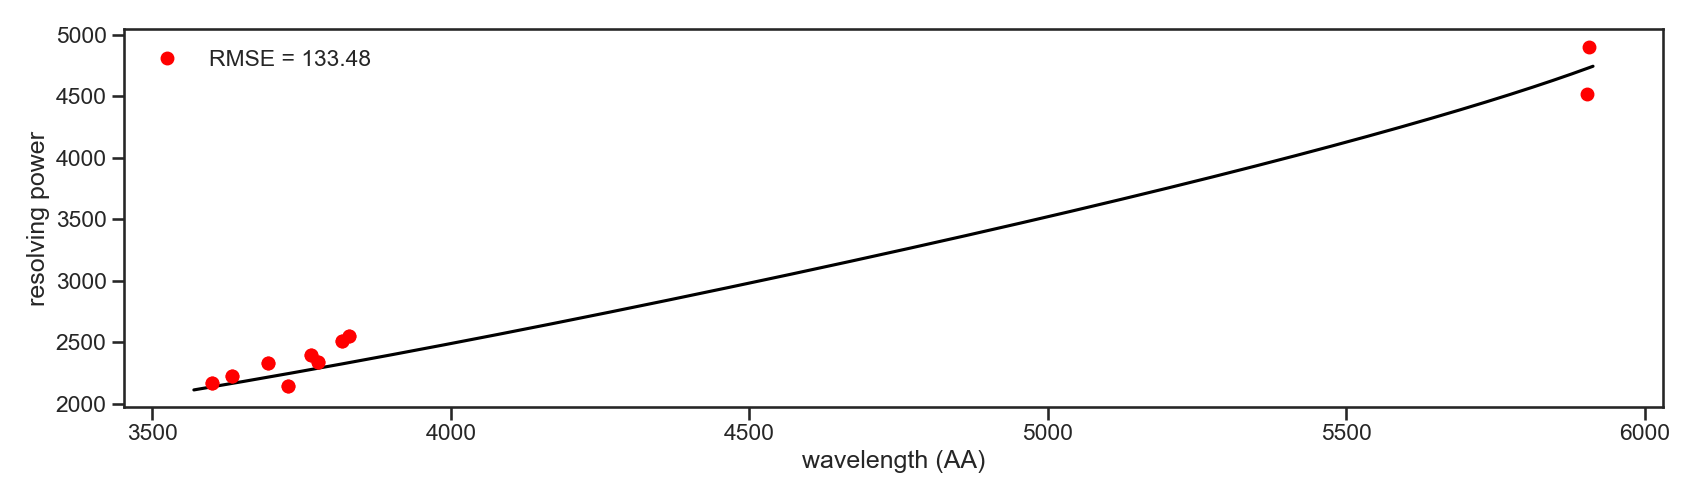

In [150]:
plt.figure(figsize=(17,5))
plt.plot(f[1].data[ised], f[1].data[ised]/f[2].data[ised], "k")

error = rmse(np.interp(ref_table[:,1], f[1].data[ised], f[1].data[ised]/f[2].data[ised]), ref_table[:,1]/fwhm)
plt.plot(ref_table[:,1], ref_table[:,1]/fwhm, "or", label=f"RMSE = {error:.2f}")

plt.legend(loc=0, frameon=False)
plt.xlabel("wavelength (AA)")
plt.ylabel("resolving power")
plt.tight_layout()